# Lags analysis

Considering economic trend variation during years, the reasearch is done to help checking time series correlations and cross-correlation of macroeconomics variables.

The analysis could be helpful for different cases, for example:
* visualize cyclicity potentials
* report multiple variables and see in which time lags reflect greater correlation
* identify in the set of periods in analysis which lags are the most correlated.

## SetUp

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

## Read datasets

In [6]:
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File ID
df_all_replaced_link = '104-UdrHarSqFCWlDxpewvWT0XmiaBMPu' 
df_normalize_link = '1hFZkvm_r3arVSv-VyUzCOStub9KLupHk'
df_mean_distance_link = '10iqaD8LEWDXpb1qKfHNNvNdVvODkW1Ap'

group1_link = '1SeBohyPghZlnyAA4m0i-jNUpsVF1IH8V'
group2_link = '1CjfgPobiWVD4I8oA8dTVLFjOpDsNbJ2J'
group3_link = '1et8qCxbgSucKb7zYkb698izsPpM2Reoa'
    
# Read files using the function
df_all_replaced = read_gdrive_to_df(df_all_replaced_link) # original data with no nan
df_normalize = read_gdrive_to_df(df_normalize_link) # normalized data (all changed by previous year difference)
df_mean_distance = read_gdrive_to_df(df_mean_distance_link) # mean distance from year for each country

# Last save groups of countries
group1 = read_gdrive_to_df(group1_link)
group2 = read_gdrive_to_df(group2_link)
group3 = read_gdrive_to_df(group3_link)

## Datasets explanation
- df_normalize: data normalized (zscore) + made difference from previous data (.diff)
- df_mean_distance: by df_normalized has been calculated for each sigle country and year the distance by mean for each year compared to the total years

### Split datasets *<u>df_normalize</u>*  and *<u>df_mean_distance</u>* in three groups. Each will contains specific countries with similarities.

In [7]:
# Get from 'df_mean_distance' the countries indices each group and split the dataframe
df = df_normalize.copy()
df.reset_index(drop=True, inplace=True)

df_norm_dist_group1 = df[df['country'].isin(group1['country'])]
df_norm_dist_group2 = df[df['country'].isin(group2['country'])]
df_norm_dist_group3 = df[df['country'].isin(group3['country'])]

In [8]:
# Get from 'df_mean_distance' the countries insides each group and split the dataframe
df = df_mean_distance.copy()
df.reset_index(drop=True, inplace=True)

df_mean_dist_group1 = df[df['country'].isin(group1['country'])]
df_mean_dist_group2 = df[df['country'].isin(group2['country'])]
df_mean_dist_group3 = df[df['country'].isin(group3['country'])]

### Dataframe following used : *<u>df_norm_dist_group1</u>* (dataframe normalized which contains countries of group1)

In [5]:
group1

,country
0,Austria
1,Belgium
2,Cyprus
3,Denmark
4,Germany
5,Luxembourg
6,Malta
7,Netherlands
8,Sweden
9,Switzerland


##  Lags analysis
Pipeline:

- **1st plot:** time series autocorrelation
- **2nd plot:** calculates the cross-correlation between the DataFrame variables provided for the specified lags
- **3th Cross:** each variable show cross-correlation with others (it is possible to choose with or not heatmap)
- **4th Most corr.:** checks each variable in which periods it is most correlated with

## 1st plot: time series autocorrelation

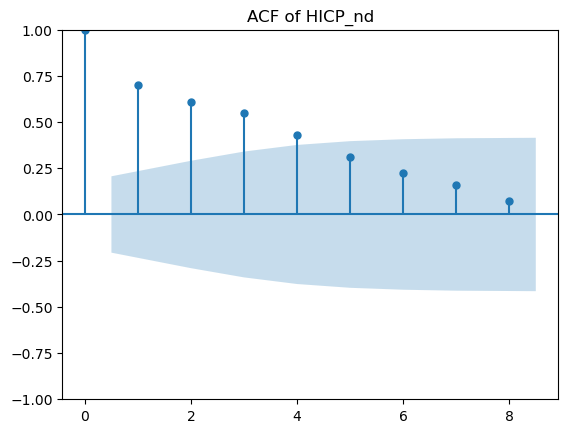

In [97]:
# Time series autocorrelation
column_check = 'HICP_nd' # variable to check

df_by_year = df_norm_dist_group1.sort_values(by='year', ascending=True) # normalized df

series = df_by_year[column_check]

# Plot
plot_acf(series, lags=8) # lags setted to 8 (customize)
plt.title(f'ACF of {column_check}')
plt.show()

## <u>Set dataframe will be used for following steps (just run code below):
1. Year (Ordinal Encoding) and add on ToTPop(%)Mean column from original dataframe (even if it is removed)
2. Remove categorical variables
3. Keep just economic variables (exclude demographic)

### Step1:
Year (Ordinal Encoding) and add on ToTPop(%)Mean column from original dataframe (even if it is removed)

In [9]:
from sklearn.preprocessing import OrdinalEncoder

def ord_enc_year_avg_country(original_df, *groups):
    
    '''
    - add on 'ToTPop(%)Mean', which rapresent population to total pop countries
    - year col trasformed with ordinal encoding
    '''

    print("Make sure your original df contains columns 'ToTPop.' (total population for country), 'year', and 'country'")
    
    modified_groups = [] # List to contain modified groups
    
    # Make iterations for each group put in the UDF
    for g in groups:
        
        # --- Set dataframe
        df_tot_pop = original_df[['country','year','ToTPop.']].dropna()
        
        # Merge dataframe
        df_test = g.copy()
        test_df = df_test.merge(df_tot_pop[['country', 'year', 'ToTPop.']], on=['country', 'year'], how='inner')

        # Modelling: move the last column to the third position
        # Get all the columns except the last one
        cols = test_df.columns.tolist()[:-1]
        
        # Insert the last column at the third position
        cols.insert(3, test_df.columns[-1])
        
        # Reorient the columns
        test_df = test_df[cols]
        
        # --- Get mean from each country to total countries present
        mean_values_per_country = test_df.groupby('country')['ToTPop.'].mean()

        # Sum all the means to get the total
        total_mean = mean_values_per_country.sum()

        # Calculate the proportion for the 'ToTPop.' column by dividing by the total
        proportions = mean_values_per_country / total_mean
        
        # Verify that the sum of the proportions is 1
        # assert proportions.sum() == 1

        epsilon = 1e-6
        assert abs(proportions.sum() - 1) < epsilon

        # Replace the values in the 'ToTPop.' column with these proportions
        test_df['ToTPop.'] = test_df['country'].map(proportions).round(4)
        
        # -- Ordinal encoding for 'year column'
        # Assuming your DataFrame is called df and the year column is 'year'
        years = test_df['year'].values.reshape(-1, 1)

        encoder = OrdinalEncoder()
        encoded_years = encoder.fit_transform(years)

        # Replace the year column with the encoded values
        test_df['year'] = encoded_years
        
        # Rename ToTPop. percentage from mean column
        test_df.rename(columns={'ToTPop.':'ToTPop(%)Mean'}, inplace=True)
        
        # Add the modified group to the list
        modified_groups.append(test_df)
        
    return modified_groups  # This must be outside the for loop

**Passed: whole original dataframe and each dataframe normalized which contains group of countries**

In [10]:
# encoded df
mod_grp_group1, mod_grp_group2, mod_grp_group3 = ord_enc_year_avg_country(df_all_replaced, df_norm_dist_group1, df_norm_dist_group2, df_norm_dist_group3)

Make sure your original df contains columns 'ToTPop.' (total population for country), 'year', and 'country'


**Concatenate each dataframe with countries in one**

In [11]:
# -- Concatenate all df to same df
mod_grp_total = pd.concat([mod_grp_group1, mod_grp_group2, mod_grp_group3], ignore_index=True)

### Step2:
Remove categorical variables

In [12]:
def remove_categorical_col(*groups_modified):
    new_dataframes = []

    for g in groups_modified:
        if 'country' in g.columns:
            country_index = g.columns.get_loc('country')
            new_df = g.iloc[:, country_index + 1:]
            new_dataframes.append(new_df)
        else:
            print("The 'country' column is not present in DataFrame, so it will not be changed.")
            new_dataframes.append(g)  # Aggiungi il DataFrame inalterato
        
    return new_dataframes

In [13]:
df_pred_group1, df_pred_group2, df_pred_group3 = remove_categorical_col(mod_grp_group1, mod_grp_group2, mod_grp_group3)

In [14]:
# -- Concatenate all df to same df
df_pred_total = pd.concat([df_pred_group1, df_pred_group2, df_pred_group3], ignore_index=True)

### Step3:
Keep just economic variables (exclude demographic)

In [15]:
# Copia del DataFrame df_prediction6
df = df_pred_group1.copy()

# Numero di anni unici
unique_year_count = df['year'].nunique()
lags = list(range(0, unique_year_count))

#-- USING JUST FOR LAGS PART
# Ordinamento del DataFrame per anno
df_demo_group1 = df.sort_values(by='year', ascending=True)

# --- Remove 'demographic' columns
cols_to_drop = ['year', 'ToTPop(%)Mean', 'ToTPop_nd', 'PopDens_nd']
df__no_demo_group1 = df_demo_group1.drop(cols_to_drop, axis=1)

## 2nd plot: cross-correlation between variable selected and others

In [17]:
def calculate_cross_correlations(df, lags: list):
    """    
    - df: The DataFrame containing the time series.
    - lags (list): A list of lags to be considered.
    
    Returns:
    - dict: dictionary with correlation tables for each variable.
    """
    
    column_selected = input('Select column to compare with others: ')
    
    # Initialize a dictionary to store correlation tables for each variable
    correlation_dict = {}

    # Iterate each variable as a variable to be shifted
    for target_var in df.columns:
        # Create an empty dataframe to store results for this variable
        correlation_table = pd.DataFrame(index=df.columns, columns=[f'lag_{i}' for i in lags])

        # Calculates the cross-correlation between the shifted target variable and any other variable for each lag
        for other_var in df.columns:
            for lag in lags:
                # Shift the target variable of "lag" periods
                shifted_var = df[target_var].shift(lag).dropna()
                
                # Extract the time series of the corresponding variable 
                # taking into account the non-NaN values of the shifted variable
                other_var_series = df[other_var].iloc[-len(shifted_var):]
                
                # Calculate the cross-correlation
                correlation = ccf(shifted_var, other_var_series)[0]
                
                # If the correlation is negative, replace with nan
                if correlation < 0:
                    correlation = np.nan
                
                # Store the value in the table
                correlation_table.loc[other_var, f'lag_{lag}'] = correlation
        
        # Add the correlation table to the dictionary
        correlation_dict[target_var] = correlation_table
    
    # Print the correlation table of the selected column
    print(f'Column_selected: {column_selected}')
    display(correlation_dict[column_selected])  
    
    return correlation_dict

In [18]:
# Get positive cross-corr beetwen variable setted and others
# Just showing positive correlation

print('Just economic variabile included (demographic are excluded)')
correlation_dict = calculate_cross_correlations(df__no_demo_group1, lags) #lag list passed previously

Just economic variabile included (demographic are excluded)
Select column to compare with others: RealGDPGR_nd
Column_selected: RealGDPGR_nd


,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
RealGDPGR_nd,1.0,0.465279,0.366048,0.321864,0.118507,0.118578,0.164763,0.037391,NaN
GrDebtToGDP_nd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GovExpToGDP_nd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IntTdGoods_nd,0.044843,NaN,NaN,0.040266,0.185479,NaN,0.026645,NaN,NaN
EmpDomCon_nd,0.095513,0.166688,0.159872,0.211186,0.376524,0.167348,0.23965,0.15184,0.157843
DepOnWork_nd,0.169761,0.052055,0.214641,0.052797,NaN,0.065006,0.053912,NaN,0.028525
EduLev3(5-8)_nd,NaN,NaN,NaN,0.217535,0.091325,0.196094,0.209331,0.086607,0.227863
InduCost_nd,0.213003,0.008568,0.026433,0.047385,0.101644,0.155762,NaN,0.148375,0.099827
HICP_nd,0.080036,0.090857,0.153053,0.118594,0.114154,0.178457,0.204451,0.285757,0.32985


**IMPORTANT: following will be pasted screenshot of output you will get from udf, because GitHub does not print colors mapping.**

### 3th Cross: each variable show cross-correlation with others (it is possible to choose with or not heatmap)

In [128]:
from statsmodels.tsa.stattools import ccf

def generate_correlation_summary(df, lags: list):
    
    chosen_style = input('Select to se heatmap (1) or min max values (2):')
    
    variables = df.columns
    num_vars = len(variables)
    num_lags = len(lags)

    correlation_tensor = np.zeros((num_vars, num_vars, num_lags))

    for i, target_var in enumerate(variables):
        for j, other_var in enumerate(variables):
            for k, lag in enumerate(lags):
                shifted_var = df[target_var].shift(lag).dropna()
                other_var_series = df[other_var].iloc[-len(shifted_var):]
                correlation = ccf(shifted_var, other_var_series)[0]
                correlation_tensor[i, j, k] = correlation

    index = pd.MultiIndex.from_product([variables, variables], names=['Target Variable', 'Other Variable'])
    df_3D = pd.DataFrame(correlation_tensor.reshape(num_vars*num_vars, num_lags), index=index, columns=[f'lag_{i}' for i in lags])

    def apply_gradient_style(df):
        df_copy = df.copy()

        for idx in df_copy.index:
            for col in df_copy.columns:
                value = df_copy.at[idx, col]

                # Check if the variable is the same
                if idx[0] == idx[1] and abs(value - 1.0) < 1e-6:
                    df_copy.at[idx, col] = np.nan

        return df_copy.style.background_gradient(cmap='RdBu', axis=None)

    def highlight_extremes(df):
        def _highlight_extremes(s):
            styles = []
            top_3 = s.nlargest(3).values
            bottom_3 = s.nsmallest(3).values
            is_same_var = s.name[0] == s.name[1]
            for value in s:
                if is_same_var or value in [1.0, -1.0]: 
                    styles.append('')
                elif value == top_3[0]:  
                    styles.append('background-color: yellowgreen')
                elif value in top_3[1:]: 
                    styles.append('background-color: yellow')
                elif value in bottom_3:
                    styles.append('background-color: lightsalmon')
                else:
                    styles.append('')
            return styles
        return df.style.apply(_highlight_extremes, axis=1)
    
    print('Variables correlated with each other are not highlighted.')
    if chosen_style == '1':
        display(apply_gradient_style(df_3D))
        return apply_gradient_style(df_3D)
    
    elif chosen_style == '2':
        display(highlight_extremes(df_3D))
        return highlight_extremes(df_3D)
    
    else:
        raise ValueError("Invalid choice. Choose 1 or 2.")

In [60]:
# heatmap cross-correlation for each variables
# exclude correlation with variable with itself in first period

print('Just economic variabile included (demographic are excluded)')
styled_df = generate_correlation_summary(df__no_demo_group1, lags)

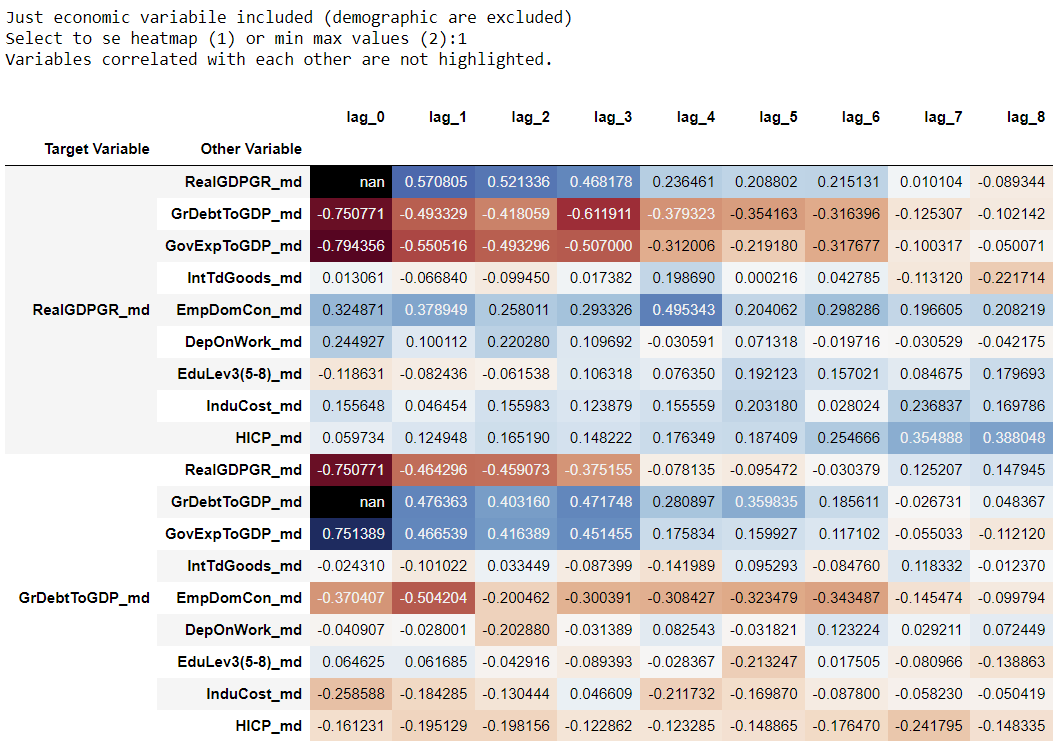

## 4th Most correlation: checks each variable in which periods it is most correlated with

In [129]:
from statsmodels.tsa.stattools import ccf
import pandas as pd

def compute_max_correlations(df_by_year, lags: list):

    # Initialize a dictionary to store correlation tables for each variable
    correlation_dict = {}

    # Iterate each variable as a variable to be shifted
    for target_var in df_by_year.columns:
        # Create an empty dataframe to store results for this variable
        correlation_table = pd.DataFrame(index=df_by_year.columns, columns=[f'lag_{i}' for i in lags])

        # Calculates the cross-correlation between the shifted target variable and any other variable for each lag
        for other_var in df_by_year.columns:
            if target_var == other_var:  # Skip comparing same variables
                continue

            for lag in lags:
                # Shift the target variable by "lag" periods
                shifted_var = df_by_year[target_var].shift(lag).dropna()
                
                # Extract the time series of the corresponding variable 
                # taking into account the non-NaN values of the shifted variable
                other_var_series = df_by_year[other_var].iloc[-len(shifted_var):]

                # Calculate the cross-correlation
                correlation = ccf(shifted_var, other_var_series)[0]

                # If the correlation is negative, replace with nan
                if correlation < 0:
                    correlation = np.nan

                # Store the value in the table
                correlation_table.loc[other_var, f'lag_{lag}'] = correlation

        # Add the correlation table to the dictionary
        correlation_dict[target_var] = correlation_table

    # Dictionary to store the maximum correlations for each variable
    max_correlations_dict = {}

    for target_var, table in correlation_dict.items():
        # Extract the maximum value and its position
        table_filled = table.fillna(-99999)

        # Extract the first two maximum values and their positions
        sorted_correlations = table_filled.stack().sort_values(ascending=False)

        max_corr_value = sorted_correlations.iloc[0]
        max_corr_location = sorted_correlations.index[0]

        second_max_corr_value = sorted_correlations.iloc[1]
        second_max_corr_location = sorted_correlations.index[1]

        # Store the results in the new dictionary
        max_correlations_dict[target_var] = {
            'max_correlation_with': max_corr_location[0],
            'lag': max_corr_location[1],
            'correlation_value': max_corr_value,
            'second_max_correlation_with': second_max_corr_location[0],
            'second_lag': second_max_corr_location[1],
            'second_correlation_value': second_max_corr_value
        }

    # Printing can be kept inside the UDF or moved outside based on the user's preference.
    for target_var, data in max_correlations_dict.items():
        print(f"For variable: {target_var}")
        print(f"Max correlation with: {data['max_correlation_with']} at {data['lag']} with value {data['correlation_value'].round(2)}")
        print(f"Second max correlation with: {data['second_max_correlation_with']} at {data['second_lag']} with value {data['second_correlation_value'].round(2)}\n")
    
    return max_correlations_dict


In [130]:
# Get from each variable the most two cross correlated variables (considering lags)
max_correlations_dict = compute_max_correlations(df__no_demo_group1, lags)

For variable: RealGDPGR_nd
Max correlation with: EmpDomCon_nd at lag_4 with value 0.38
Second max correlation with: HICP_nd at lag_8 with value 0.33

For variable: GrDebtToGDP_nd
Max correlation with: GovExpToGDP_nd at lag_0 with value 0.74
Second max correlation with: GovExpToGDP_nd at lag_1 with value 0.46

For variable: GovExpToGDP_nd
Max correlation with: GrDebtToGDP_nd at lag_0 with value 0.74
Second max correlation with: GrDebtToGDP_nd at lag_3 with value 0.53

For variable: IntTdGoods_nd
Max correlation with: GrDebtToGDP_nd at lag_5 with value 0.24
Second max correlation with: EmpDomCon_nd at lag_5 with value 0.2

For variable: EmpDomCon_nd
Max correlation with: RealGDPGR_nd at lag_2 with value 0.27
Second max correlation with: HICP_nd at lag_0 with value 0.24

For variable: DepOnWork_nd
Max correlation with: RealGDPGR_nd at lag_4 with value 0.26
Second max correlation with: RealGDPGR_nd at lag_5 with value 0.25

For variable: EduLev3(5-8)_nd
Max correlation with: EmpDomCon_nd a